In [4]:
import time

In [5]:
%%time
#========================================================================================================================#
#                                              IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pyart
import pandas as pd
import proplot as pplt
import numpy as np
import glob
from datetime import datetime
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

#========================================================================================================================#
#                                                 DIRETÓRIOS
#========================================================================================================================#
dir_input = 'VOLUMETRICOS/'
dir_output = '/Users/enriq/Downloads/PROCESSAMENTO_PYTHON/ARTIGO_LITORAL_NORTE_2023/output/01_netcdf_cappi/'

#========================================================================================================================#
#                                                 LISTA DOS ARQUIVOS
#========================================================================================================================#
files = sorted(glob.glob(f'{dir_input}PNOVA2-2*HDF5')) # PNOVA2-20230218000002.HDF5
files = files[0:1]

#========================================================================================================================#
#                                                 PROCESSAMENTO
#========================================================================================================================#
for file in files:

    print('PROCESSANDO ===>>', file)

    #--------------------------------------------------------------#
    #                     LEITURA DO DADO
    #--------------------------------------------------------------#
    # leitura do arquivo
    radar = pyart.aux_io.read_gamic(f'{file}')
    
    # extrai a data e horário do radar
    ano = str(pyart.util.datetime_from_grid(radar).year)
    mes = str(pyart.util.datetime_from_grid(radar).month).zfill(2)
    dia = str(pyart.util.datetime_from_grid(radar).day).zfill(2)
    hor = str(pyart.util.datetime_from_grid(radar).hour).zfill(2)
    min = str(pyart.util.datetime_from_grid(radar).minute).zfill(2)
    sec = str(pyart.util.datetime_from_grid(radar).second).zfill(2)

    # extrai a latitude, longitude e altitude do radar
    lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
    altitude = radar.altitude['data'][0]

    variaveis = pd.DataFrame(list(radar.fields))
    #print(variaveis)
    
    print('...... 1. Extraiu informações da data')
        
    #--------------------------------------------------------------#
    #                  CALCULA PRECIPITAÇÃO
    #--------------------------------------------------------------#
    # a) Z-R
    chuva_z = pyart.retrieve.est_rain_rate_z(radar, refl_field='corrected_reflectivity')

    # b) KDP-R
    chuva_kdp = pyart.retrieve.est_rain_rate_kdp(radar, kdp_field='specific_differential_phase')

    # c) Z-R e KDP-R
    chuva_z_kdp = pyart.retrieve.est_rain_rate_zkdp(radar, refl_field='corrected_reflectivity', thresh_max=True, thresh=40)

    # adiciona os campos criados na estrutura do objeto "radar"
    radar.add_field('rainrate_z', chuva_z)
    radar.add_field('rainrate_kdp', chuva_kdp)
    radar.add_field('rainrate_z_kdp', chuva_z_kdp)

    # d) Z-ZDR-KDP
    # guarda os campos de cada variável
    refl = radar.fields['corrected_reflectivity']['data']
    zdr = radar.fields['corrected_differential_reflectivity']['data']
    kdp = radar.fields['specific_differential_phase']['data']
    
    # chuva usando somente KDP
    rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)
    
    # Marshall Palmer para Z-R
    z = np.ma.power(10.0, refl/10)
    r_zr = (np.ma.power(z/200, 1/1.6))
    
    # copia o campo r_zr como matriz de saida
    rain = r_zr
    
    # agora verifica os limiares para uso com Z-ZDR-KDP
    idx = np.where(r_zr <= 6)
    rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))
    
    idx = np.where(r_zr > 6)
    rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))
    
    idx = np.where(r_zr > 50)
    rain[idx] = rkdp[idx]
    
    # ADICIONA O CAMPO DE PRECIPITAÇÃO
    radar.add_field_like('corrected_reflectivity', 'rainrate_z_zdr_kdp', rain)
    radar.fields['rainrate_z_zdr_kdp']['units'] = 'mm/h'
    radar.fields['rainrate_z_zdr_kdp']['standard_name'] = 'Rain_Rate'
    radar.fields['rainrate_z_zdr_kdp']['long_name'] = 'Rain Rate'
    print('...... 2. Calculou campo de taxa de precipitação')
    
    #--------------------------------------------------------------#
    #                      GERA CAPPI
    #--------------------------------------------------------------#
    cappi = pyart.map.grid_from_radars(radar,
                                       grid_shape=(13, 500, 500),
                                       grid_limits=((3000 - altitude, 15000 - altitude),
                                                    (-250_000., 250_000.),
                                                    (-250_000., 250_000.)),
                                       grid_origin = (lat_radar, lon_radar),
                                       gridding_algo='map_gates_to_grid',
                                       roi_func='dist_beam', min_radius=2000.0,
                                       weighting_function='Nearest',
                                       fields=['corrected_reflectivity', 'corrected_differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio',
                                               'corrected_velocity',
                                               'rainrate_z', 'rainrate_kdp', 'rainrate_z_kdp', 'rainrate_z_zdr_kdp'])
    print('...... 3. Gerou CAPPI')
     
    #-------------------------------------------------------#
    #           SALVA ARQUIVO NO FORMATO NETCDF
    #-------------------------------------------------------#
    # transforma para Xarray
    cappi_dataset = cappi.to_xarray() # cappi_3d = np.zeros((z_grid_points, y_grid_points, x_grid_points)) # cappi_3d[alturas, latitudes, longitudes])
    print('...... 4. Transformou para DataSet')

    # transforma o dataset para array: (time, z, y, x)
    rainrate_z_values = cappi_dataset['rainrate_z'][0,:,:,:].values
    rainrate_kdp_values = cappi_dataset['rainrate_kdp'][0,:,:,:].values
    rainrate_z_kdp_values = cappi_dataset['rainrate_z_kdp'][0,:,:,:].values
    rainrate_z_zdr_kdp_values = cappi_dataset['rainrate_z_zdr_kdp'][0,:,:,:].values
    
    dbz_values = cappi_dataset['corrected_reflectivity'][0,:,:,:].values 
    zdr_values = cappi_dataset['corrected_differential_reflectivity'][0,:,:,:].values 
    kdp_values = cappi_dataset['specific_differential_phase'][0,:,:,:].values 
    cor_values = cappi_dataset['cross_correlation_ratio'][0,:,:,:].values 
    vel_values = cappi_dataset['corrected_velocity'][0,:,:,:].values 

    # cria a dimensão do tempo com valor zero
    rainrate_z_values = rainrate_z_values[np.newaxis,:,:,:] 
    rainrate_kdp_values = rainrate_kdp_values[np.newaxis,:,:,:] 
    rainrate_z_kdp_values = rainrate_z_kdp_values[np.newaxis,:,:,:] 
    rainrate_z_zdr_kdp_values = rainrate_z_zdr_kdp_values[np.newaxis,:,:,:] 
    
    dbz_values = dbz_values[np.newaxis,:,:,:] 
    zdr_values = zdr_values[np.newaxis,:,:,:] 
    kdp_values = kdp_values[np.newaxis,:,:,:] 
    cor_values = cor_values[np.newaxis,:,:,:] 
    vel_values = vel_values[np.newaxis,:,:,:] 

    # define encoding para compactação dos dados
    encoding = {
                'rainrate_z': {'zlib': True},
                'rainrate_kdp': {'zlib': True},
                'rainrate_z_kdp': {'zlib': True},
                'rainrate_z_zdr_kdp': {'zlib': True},
                
                'corrected_reflectivity': {'zlib': True},
                'corrected_differential_reflectivity': {'zlib': True},
                'specific_differential_phase': {'zlib': True},
                'cross_correlation_ratio': {'zlib': True},
                'corrected_velocity': {'zlib': True}
               }

    # define as variáveis
    data_vars = {
                 'rainrate_z': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_z_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_kdp': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_kdp_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_z_kdp': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_z_kdp_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 'rainrate_z_zdr_kdp': (('time', 'alt', 'lat', 'lon'), np.flipud(rainrate_z_zdr_kdp_values), {'units': 'mm/h', 'long_name': 'Taxa de Precipitação', '_FillValue': 0}),  
                 
                 'corrected_reflectivity': (('time', 'alt', 'lat', 'lon'), np.flipud(dbz_values), {'units': 'dBZ', 'long_name': 'Reflectivity', '_FillValue': 0}),
                 'corrected_differential_reflectivity': (('time', 'alt', 'lat', 'lon'), np.flipud(zdr_values), {'units': 'dB', 'long_name': 'Differential Reflectivity', '_FillValue': 0}),
                 'specific_differential_phase': (('time', 'alt', 'lat', 'lon'), np.flipud(kdp_values), {'units': 'degree/km', 'long_name': 'Specific Differential Phase', '_FillValue': 0}),
                 'cross_correlation_ratio': (('time', 'alt', 'lat', 'lon'), np.flipud(cor_values), {'units': '#', 'long_name': 'Cross Correlation Ratio', '_FillValue': 0}),
                 'corrected_velocity': (('time', 'alt', 'lat', 'lon'), np.flipud(vel_values), {'units': 'm/s', 'long_name': 'Corrected Velocity', '_FillValue': 0})        
                }
  
    # coordenadas 
    coords = {'time': cappi_dataset['time'].values, 'alt': cappi_dataset['z'].values + altitude, 'lat': cappi_dataset['lat'][:,0].values, 'lon': cappi_dataset['lon'][:,0].values}

    # atributos  
    attrs = {'description': 'Constant Altitude Plan Position Indicator (CAPPI) de 3 a 15 km de altitude com resolução espacial horizontal e vertical de 1 km para o radar da FCTH (SP)',                             
             'creation_data': str(datetime.now()), 
             'author':'Enrique V. Mattos',
             'email': 'enrique@unifei.edu.br'}

    # gera Dataset
    dataset = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

    # salva arquivo netcdf
    dataset.to_netcdf(f'{dir_output}cappi_3000m_to_15000m_fcth_{ano}{mes}{dia}_{hor}{min}{sec}.nc',  encoding=encoding)
    print('...... 5. Salvou aruivo NETCDF')

PROCESSANDO ===>> VOLUMETRICOS\PNOVA2-20230218000002.HDF5
...... 1. Extraiu informações da data
...... 2. Calculou campo de taxa de precipitação
...... 3. Gerou CAPPI
...... 4. Transformou para DataSet
...... 5. Salvou aruivo NETCDF
CPU times: total: 1min 32s
Wall time: 1min 37s


In [9]:
variaveis = pd.DataFrame(list(radar.fields))
print(variaveis)

                                      0
0                corrected_reflectivity
1                          reflectivity
2                    corrected_velocity
3                        spectrum_width
4   corrected_differential_reflectivity
5          corrected_differential_phase
6                    differential_phase
7           specific_differential_phase
8               cross_correlation_ratio
9                            rainrate_z
10                         rainrate_kdp
11                       rainrate_z_kdp
12                   rainrate_z_zdr_kdp


In [8]:
import xarray as xr
ds = xr.open_dataset(f'{dir_output}cappi_3000m_to_15000m_fcth_{ano}{mes}{dia}_{hor}{min}{sec}.nc')
ds

<xarray.Dataset>
Dimensions:                              (time: 1, alt: 13, lat: 500, lon: 500)
Coordinates:
  * time                                 (time) datetime64[ns] 2023-02-18T00:...
  * alt                                  (alt) float64 3e+03 4e+03 ... 1.5e+04
  * lat                                  (lat) float64 -25.83 -25.82 ... -21.33
  * lon                                  (lon) float64 -48.47 -48.47 ... -48.39
Data variables:
    rainrate_z                           (time, alt, lat, lon) float32 ...
    rainrate_kdp                         (time, alt, lat, lon) float32 ...
    rainrate_z_kdp                       (time, alt, lat, lon) float32 ...
    rainrate_z_zdr_kdp                   (time, alt, lat, lon) float32 ...
    corrected_reflectivity               (time, alt, lat, lon) float32 ...
    corrected_differential_reflectivity  (time, alt, lat, lon) float32 ...
    specific_differential_phase          (time, alt, lat, lon) float32 ...
    cross_correlation_ratio              (time, alt, lat, lon) float32 ...
    corrected_velocity                   (time, alt, lat, lon) float32 ...
Attributes:
    description:    Constant Altitude Plan Position Indicator (CAPPI) de 3 a ...
    creation_data:  2024-09-16 20:49:02.192011
    author:         Enrique V. Mattos
    email:          enrique@unifei.edu.br

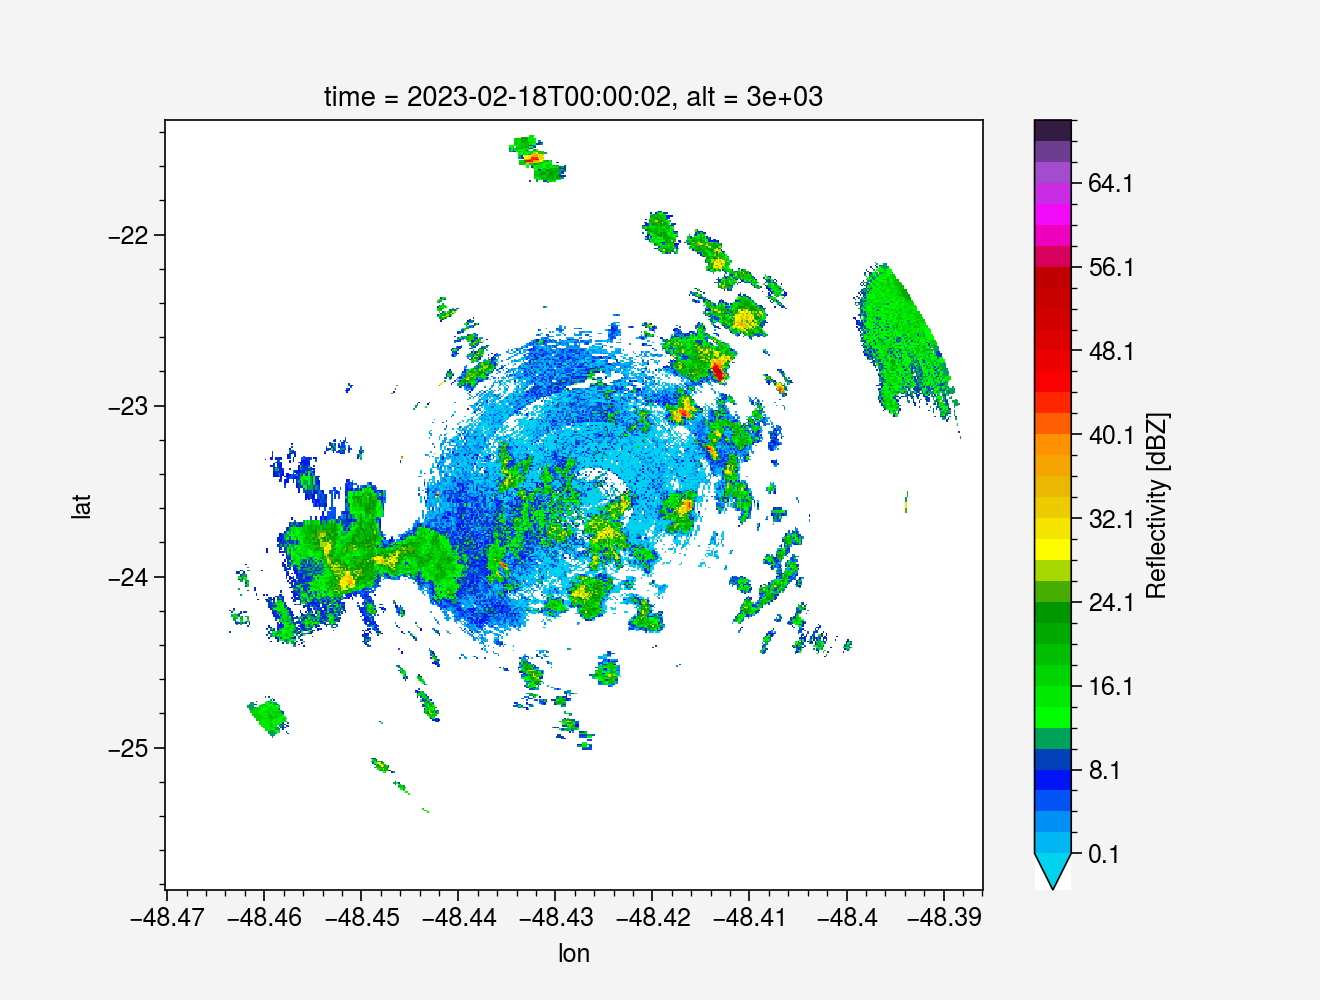

In [22]:
ds['corrected_reflectivity'][0,0,:,:].plot(figsize=(6.6,5), 
                                           cmap='pyart_NWSRef', 
                                           vmin=0.1, vmax=70, 
                                           levels=pplt.arange(0.1, 70., 2.0))

In [ ]:
ds['corrected_reflectivity'][0,0,:,:].plot(figsize=(6.6,5), 
                                           cmap='pyart_NWSRef', 
                                           vmin=0.1, vmax=70, 
                                           levels=pplt.arange(0.1, 70., 2.0))

In [ ]:
ds['corrected_reflectivity'][0,0,:,:].plot(figsize=(6.6,5), 
                                           cmap='pyart_NWSRef', 
                                           vmin=0.1, vmax=70, 
                                           levels=pplt.arange(0.1, 70., 2.0))

In [ ]:
ds['corrected_reflectivity'][0,0,:,:].plot(figsize=(6.6,5), 
                                           cmap='pyart_NWSRef', 
                                           vmin=0.1, vmax=70, 
                                           levels=pplt.arange(0.1, 70., 2.0))

In [ ]:
ds['corrected_reflectivity'][0,0,:,:].plot(figsize=(6.6,5), 
                                           cmap='pyart_NWSRef', 
                                           vmin=0.1, vmax=70, 
                                           levels=pplt.arange(0.1, 70., 2.0))

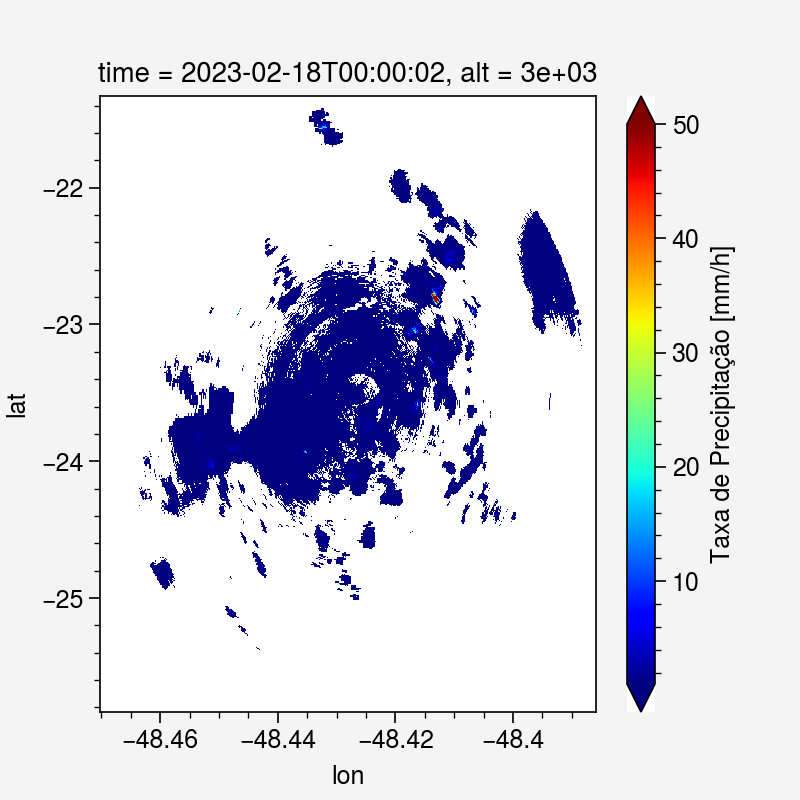

In [16]:
ds['rainrate_z'][0,0,:,:].plot(cmap='jet', vmin=1, vmax=50)